In [24]:
import numpy as np
import keras
from keras.models import Sequential
from keras.preprocessing.image import img_to_array, load_img
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.utils.layer_utils import count_params
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#%matplotlib inline

In [25]:
import os
os. chdir("C:/Users/samfr/PycharmProjects/upg/datasets")
print(os.getcwd())

C:\Users\samfr\PycharmProjects\upg\datasets


In [26]:
train_path = '/Users/samfr/PycharmProjects/upg/datasets/train'
valid_path = '/Users/samfr/PycharmProjects/upg/datasets/valid'
test_path = '/Users/samfr/PycharmProjects/upg/datasets/test'

In [27]:
train_batches = ImageDataGenerator(rescale=None,
        rotation_range=30,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=False).flow_from_directory(directory=train_path, 
                            target_size=(224,224), 
                            classes=['COVID-19','NORMAL','Viral_Pneumonia'], 
                            batch_size=10)

Found 2721 images belonging to 3 classes.


In [28]:
valid_batches = ImageDataGenerator(rescale=None,
        rotation_range=30,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=False).flow_from_directory(directory=valid_path, 
                            target_size=(224,224), 
                            classes=['COVID-19','NORMAL','Viral_Pneumonia'], 
                            batch_size=10)

Found 583 images belonging to 3 classes.


In [29]:
test_batches = ImageDataGenerator().flow_from_directory(directory=test_path, target_size=(224,224), classes=['COVID-19','NORMAL','Viral_Pneumonia'], batch_size=10)

Found 582 images belonging to 3 classes.


## Let's look at the images

Below represents the classes:

 - "0" - Covid-19 Positive 
 - "1" - NORMAL 
 - "2" - Viral_Pneumonia 

In [ ]:
# # Covid-19 Positive Patient

# %pylab inline
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

# img=mpimg.imread(r'C:\Users\samfr\PycharmProjects\upg\datasets\test\COVID-19\COVID-19(171).png')
# imgplot = plt.imshow(img)
# plt=plt.title('Covid-19 Positive Patient Chest X-ray ')

In [ ]:
# # Normal Patient

# %pylab inline
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

# img=mpimg.imread(r'C:\Users\samfr\PycharmProjects\upg\datasets\test\NORMAL\NORMAL (801).png')
# imgplot = plt.imshow(img)
# plt=plt.title('NORMAL Patient Chest X-ray ')

In [ ]:
# # Viral_Pneumonia Patient

# %pylab inline
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

# img=mpimg.imread(r'C:\Users\samfr\PycharmProjects\upg\datasets\test\Viral_Pneumonia\Viral Pneumonia (901).png')
# imgplot = plt.imshow(img)
# plt=plt.title('Viral_Pneumonia Patient Chest X-ray ')

### Transfer learning using Pre-trained model as Feature Extractor

In [30]:
# Download model - Internet connection needed
vgg16_model = keras.applications.vgg16.VGG16()

vgg16_model.summary()

type(vgg16_model)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

tensorflow.python.keras.engine.functional.Functional

In [31]:
# transforming this model into sequential model
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [32]:
# verify model params
# assert count_params(model.non_trainable_weights) == 0
# assert count_params(model.trainable_weights) == 134260544

for layer in model.layers:
    layer.trainable = False

model.add(Dense(units=3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [33]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint

filepath = "three_classification_problem_model_solved_VGG16_final.h5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [34]:
#Train the fine-tuned VGG16 model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

results = model.fit_generator(generator=train_batches, steps_per_epoch=4,
                    validation_data=valid_batches, validation_steps=4, epochs=50, verbose=2,callbacks = callbacks_list) #2/1/-1

#model.save('three_classification_problem_model_solved_VGG16.h5')

C:\Users\samfr\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
4/4 - 17s - loss: 1.2076 - accuracy: 0.5000 - val_loss: 1.3005 - val_accuracy: 0.3750

Epoch 00001: val_accuracy improved from -inf to 0.37500, saving model to three_classification_problem_model_solved_VGG16_final.h5
Epoch 2/50
4/4 - 15s - loss: 1.0883 - accuracy: 0.4250 - val_loss: 0.9772 - val_accuracy: 0.4500

Epoch 00002: val_accuracy improved from 0.37500 to 0.45000, saving model to three_classification_problem_model_solved_VGG16_final.h5
Epoch 3/50
4/4 - 15s - loss: 1.0334 - accuracy: 0.4500 - val_loss: 0.7214 - val_accuracy: 0.5500

Epoch 00003: val_accuracy improved from 0.45000 to 0.55000, saving model to three_classification_problem_model_solved_VGG16_final.h5
Epoch 4/50
4/4 - 15s - loss: 1.1041 - accuracy: 0.5500 - val_loss: 0.8794 - val_accuracy: 0.5250

Epoch 00004: val_accuracy did not improve from 0.55000
Epoch 5/50
4/4 - 19s - loss: 0.9763 - accuracy: 0.5500 - val_loss: 0.7052 - val_accuracy: 0.6250

Epoch 00005: val_accuracy improved from 0.55000 to 0.62500,


Epoch 00049: val_accuracy did not improve from 0.97500
Epoch 50/50
4/4 - 16s - loss: 0.2750 - accuracy: 0.9000 - val_loss: 0.2444 - val_accuracy: 0.9250

Epoch 00050: val_accuracy did not improve from 0.97500


### Let's plot the performance of Deep Learning model

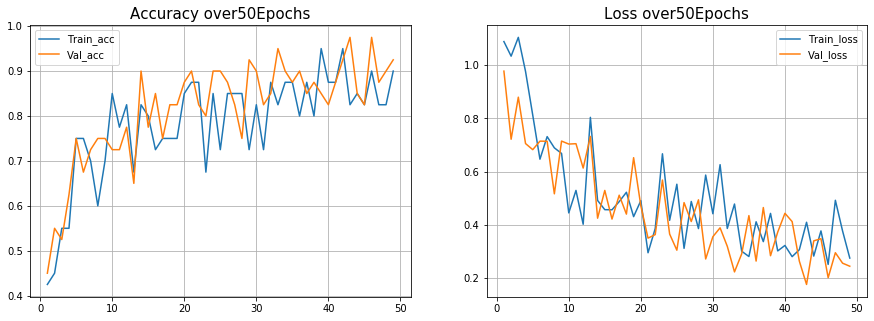

In [35]:
import matplotlib.pyplot as plt
def plot_acc_loss(results, epochs):
 acc = results.history['accuracy']
 loss = results.history['loss']
 val_acc = results.history['val_accuracy']
 val_loss = results.history['val_loss']
 plt.figure(figsize=(15, 5))
 plt.subplot(121)
 plt.plot(range(1,epochs), acc[1:], label='Train_acc')
 plt.plot(range(1,epochs), val_acc[1:], label='Val_acc')
 plt.title('Accuracy over' + str(epochs) + 'Epochs', size=15)
 plt.legend()
 plt.grid(True)
 plt.subplot(122)
 plt.plot(range(1,epochs), loss[1:], label='Train_loss')
 plt.plot(range(1,epochs), val_loss[1:], label='Val_loss')
 plt.title('Loss over' + str(epochs) +  'Epochs', size=15)
 plt.legend()
 plt.grid(True)
 plt.show()
 
plot_acc_loss(results, 50)

# Let's create the Confusion Matrix

In [36]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os
from keras.preprocessing.image import img_to_array, load_img

In [37]:
# images folder
covid_path = 'C:\\Users\\samfr\\PycharmProjects\\upg\\datasets\\valid\\COVID-19'
normal_path = 'C:\\Users\\samfr\\PycharmProjects\\upg\\datasets\\valid\\NORMAL'
pneumonia_path = 'C:\\Users\\samfr\\PycharmProjects\\upg\\datasets\\valid\\Viral_Pneumonia'

# path to model
model_path = '/Users/samfr/PycharmProjects/upg/datasets/three_classification_problem_model_solved_VGG16_final.h5'

# dimensions of images
img_width, img_height = 224, 224

# load the trained model
model_loaded = load_model(model_path)
model_loaded.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
#######################################################
## COVID-19
# load all images into a list
images_covid = []
for img in os.listdir(covid_path):
    img = os.path.join(covid_path, img)
    img = image.load_img(img, target_size=(img_width, img_height))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    images_covid.append(img)
    
    # stack up images list to pass for prediction
images_covid = np.vstack(images_covid)
covid_pred = model_loaded.predict_classes(images_covid, batch_size=10)
covid_len = (len(list(covid_pred)))
covid_len

C:\Users\samfr\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


180

In [39]:
##########################################################
##  NORMAL
# load all images into a list
images_normal = []
for img in os.listdir(normal_path):
    img = os.path.join(normal_path, img)
    img = image.load_img(img, target_size=(img_width, img_height))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    images_normal.append(img)
    
    # stack up images list to pass for prediction
images_normal = np.vstack(images_normal)
normal_pred = model_loaded.predict_classes(images_normal, batch_size=10)
normal_len = (len(list(normal_pred)))
normal_len

201

In [40]:
############################################################
## Pneumonia
# load all images into a list
images_pneumonia = []
for img in os.listdir(pneumonia_path):
    img = os.path.join(pneumonia_path, img)
    img = image.load_img(img, target_size=(img_width, img_height))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    images_pneumonia.append(img)
    
    # stack up images list to pass for prediction
images_pneumonia = np.vstack(images_pneumonia)
pneumonia_pred = model_loaded.predict_classes(images_pneumonia, batch_size=10)
pneumonia_len = (len(list(pneumonia_pred)))
pneumonia_len

202

In [41]:
covid_true = np.zeros((covid_len,), dtype=int)
normal_true = np.ones((normal_len,), dtype=int)
pneumonia_true = 2*np.ones((pneumonia_len,), dtype=int)

In [42]:
type(pneumonia_true)

numpy.ndarray

In [43]:
type(pneumonia_pred)

numpy.ndarray

In [44]:
pred_concat = np.concatenate((covid_pred, normal_pred,pneumonia_pred), axis=0)

In [45]:
true_concat = np.concatenate((covid_true, normal_true,pneumonia_true), axis=0)

In [63]:
import sklearn.metrics as metrics

confusion_matrix(true_concat, pred_concat)
print('Classification Report')
target_names = ['COVID-19','NORMAL','Viral_Pneumonia']
print(metrics.classification_report(true_concat, pred_concat, target_names=target_names))

Classification Report
                 precision    recall  f1-score   support

       COVID-19       0.95      0.92      0.93       180
         NORMAL       0.79      0.93      0.86       201
Viral_Pneumonia       0.86      0.74      0.80       202

       accuracy                           0.86       583
      macro avg       0.87      0.86      0.86       583
   weighted avg       0.87      0.86      0.86       583



In [64]:
confusion_matrix(true_concat, pred_concat)

array([[165,   2,  13],
       [  3, 187,  11],
       [  5,  47, 150]], dtype=int64)

## Let's plot ROC & AUC

In [47]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score


all_labels = ['COVID-19','NORMAL','Viral_Pneumonia']

y_test = true_concat
y_pred = pred_concat

0.8964122814800689

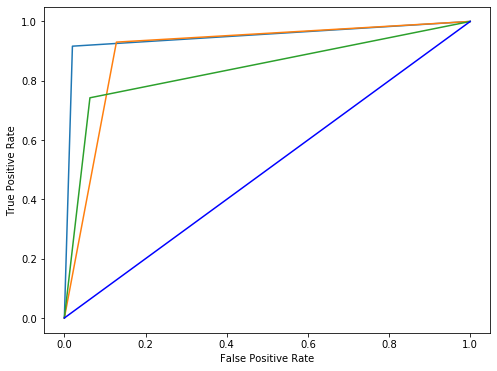

In [48]:
# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (8, 6))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(all_labels): # all_labels: no of the labels, for ex. ['cat', 'dog', 'rat']
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

# calling
#true_concat.reset() # resetting generator
# y_pred = model.predict_generator(y_test, verbose = True)
# y_pred = np.argmax(y_pred, axis=1)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
multiclass_roc_auc_score(y_test, y_pred)

In [49]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
#from plot_conf_matr import plot_confusion_matrix

In [50]:
import numpy as np
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes, figname,normalize=False,title="Confusion matrix",cmap=plt.cm.Blues):
    import numpy as np
    import matplotlib.pyplot as plt
    import itertools
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix")
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")
        plt.ylabel("True label")
        plt.xlabel("Predicted label")
        plt.tight_layout()
        plt.savefig(figname)
    


Confusion matrix


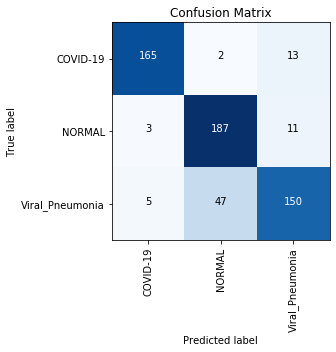

In [62]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes = ['COVID-19','NORMAL','Viral_Pneumonia'], title='Confusion Matrix', normalize=False, figname = 'Confusion_matrix_concrete.jpg')

# Prediction

Test Dataset has been kept untouched and used below to test model performance on unseen data

## Covid-19 Prediction Accuracy

In [52]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os

In [53]:
# image folder
covid_path = 'C:\\Users\\samfr\\PycharmProjects\\upg\\datasets\\test\\COVID-19'
# path to model
model = model_loaded
# dimensions of images
img_width, img_height = 224, 224


# load all images into a list
images = []
for img in os.listdir(covid_path):
    img = os.path.join(covid_path, img)
    img = image.load_img(img, target_size=(img_width, img_height))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    images.append(img)
    
    # stack up images list to pass for prediction
images = np.vstack(images)
classes = model.predict_classes(images, batch_size=10)
print(classes)

C:\Users\samfr\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0
 0 0 2 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [54]:
# Let's convert it to List
pred_counter = list(classes)
print(pred_counter)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [55]:
# Let's check the accuracy od Covid-19

from collections import Counter

covid_occurance= Counter(pred_counter)[0]
covid_pred_accuracy = (covid_occurance/len(pred_counter))*100

print(covid_pred_accuracy)

95.55555555555556


## Normal Prediction Accuracy

In [56]:
# image folder
normal_path = 'C:\\Users\\samfr\\PycharmProjects\\upg\\datasets\\test\\NORMAL'
# path to model
model = model_loaded
# dimensions of images
img_width, img_height = 224, 224

# load all images into a list
images = []
for img in os.listdir(normal_path):
    img = os.path.join(normal_path, img)
    img = image.load_img(img, target_size=(img_width, img_height))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    images.append(img)
    
    # stack up images list to pass for prediction
images = np.vstack(images)
classes = model.predict_classes(images, batch_size=10)
print(classes)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 2 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 2 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 1 1 1 2 1 1 1 1 1 1 2 1 0 1 1 1]


In [57]:
# Let's convert it to List
pred_counter = list(classes)
#print(pred_counter)

In [58]:
# Let's check the accuracy of Normal patients

from collections import Counter

normal_occurance = Counter(pred_counter)[1]
normal_pred_accuracy = (normal_occurance/len(pred_counter))*100

print(normal_pred_accuracy)

94.02985074626866


## Viral Pneumonia Prediction Accuracy

In [59]:
# image folder
pneumonia_path = 'C:\\Users\\samfr\\PycharmProjects\\upg\\datasets\\test\\Viral_Pneumonia'
# path to model
model = model_loaded
# dimensions of images
img_width, img_height = 224, 224

# load all images into a list
images = []
for img in os.listdir(pneumonia_path):
    img = os.path.join(pneumonia_path, img)
    img = image.load_img(img, target_size=(img_width, img_height))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    images.append(img)
    
    # stack up images list to pass for prediction
images = np.vstack(images)
classes = model.predict_classes(images, batch_size=10)
print(classes)

[1 1 1 1 2 2 2 2 2 1 2 2 2 2 2 2 2 1 0 2 1 2 2 1 2 2 2 1 2 2 1 2 0 2 2 2 2
 2 2 1 2 1 1 1 1 2 0 2 1 2 2 2 2 2 2 2 0 2 1 2 2 2 2 2 2 2 2 1 1 2 1 2 0 2
 1 1 2 1 1 2 2 1 1 1 2 2 1 2 2 1 2 1 1 1 2 2 1 1 2 2 2 2 2 2 2 2 2 1 2 2 1
 1 1 2 2 2 2 1 1 2 1 2 1 2 1 2 1 2 2 2 2 2 1 2 2 2 2 1 1 2 1 1 1 1 1 2 1 1
 2 1 2 2 2 2 2 2 2 2 1 2 2 1 2 2 1 2 1 2 2 2 2 2 2 2 1 1 1 1 2 2 2 2 2 2 1
 2 2 2 2 2 2 2 2 2 1 2 2 1 1 2 2]


In [60]:
# Let's convert it to List
pred_counter = list(classes)
print(pred_counter)

[1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 0, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2]


In [61]:
# Let's check the accuracy of Viral Pneumonia

from collections import Counter

pneumonia_occurance = Counter(pred_counter)[2]
pneumonia_pred_accuracy = (pneumonia_occurance/len(pred_counter))*100

print(pneumonia_pred_accuracy)

64.17910447761194
